In [ ]:
import zipfile
!wget https://drive.google.com/uc?export=download&id=16y2xEwwuf1v_W0BUDv1thzpNu_dnaJZ1
!unzip Real and Fake Face Detection Dataset.zip

--2024-06-29 20:08:38--  https://drive.google.com/uc?export=download
Resolving drive.google.com (drive.google.com)... 172.217.214.101, 172.217.214.138, 172.217.214.102, ...
Connecting to drive.google.com (drive.google.com)|172.217.214.101|:443... connected.
HTTP request sent, awaiting response... 400 Bad Request
2024-06-29 20:08:38 ERROR 400: Bad Request.

unzip:  cannot find or open Real, Real.zip or Real.ZIP.


**Import Necessary Libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Check TensorFlow version
print(tf.__version__)


2.15.0


**Split the Data into Training and Validation Sets**

In [ ]:
# Define the paths to the dataset folders
dataset_dir = '/content/drive/MyDrive/Real and Fake Face Detection Dataset'
real_dir = os.path.join(dataset_dir, 'Real')
fake_dir = os.path.join(dataset_dir, 'Fake')

# Create lists to hold file paths and labels
file_paths = []
labels = []

# Add real images
for file_name in os.listdir(real_dir):
    file_paths.append(os.path.join(real_dir, file_name))
    labels.append('Real')

# Add fake images
for file_name in os.listdir(fake_dir):
    file_paths.append(os.path.join(fake_dir, file_name))
    labels.append('Fake')

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)

# Split the data
train_paths, val_paths, train_labels, val_labels = train_test_split(file_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Convert to DataFrame for use with ImageDataGenerator
train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
val_df = pd.DataFrame({'filename': val_paths, 'class': val_labels})


**Create ImageDataGenerators**

In [ ]:
# Create ImageDataGenerators for training and validation with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 1632 validated image filenames belonging to 2 classes.
Found 408 validated image filenames belonging to 2 classes.


**Create the Model**

In [ ]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 36, 36, 64)       

**Train the Model**

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)


Epoch 1/20
51/51 [==============================] - 133s 3s/step - loss: 1.5841 - accuracy: 0.5233 - val_loss: 1.1514 - val_accuracy: 0.5312
Epoch 2/20
51/51 [==============================] - 130s 3s/step - loss: 1.0289 - accuracy: 0.5190 - val_loss: 0.9392 - val_accuracy: 0.5286
Epoch 3/20
51/51 [==============================] - 128s 3s/step - loss: 0.8920 - accuracy: 0.5294 - val_loss: 0.8538 - val_accuracy: 0.5208
Epoch 4/20
51/51 [==============================] - 128s 3s/step - loss: 0.8294 - accuracy: 0.5294 - val_loss: 0.8087 - val_accuracy: 0.5312
Epoch 5/20
51/51 [==============================] - 130s 3s/step - loss: 0.7954 - accuracy: 0.5294 - val_loss: 0.7830 - val_accuracy: 0.5339
Epoch 6/20
51/51 [==============================] - 129s 3s/step - loss: 0.7750 - accuracy: 0.5294 - val_loss: 0.7661 - val_accuracy: 0.5391
Epoch 7/20
51/51 [==============================] - 129s 3s/step - loss: 0.7617 - accuracy: 0.5294 - val_loss: 0.7560 - val_accuracy: 0.5312
Epoch 8/20
51

**Evaluate the Model**

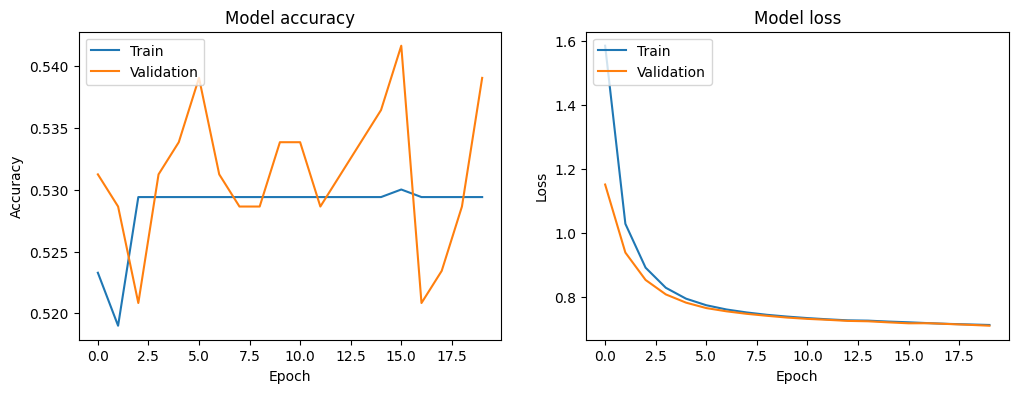

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


**Print Predicted and Actual Labels**

In [ ]:
# Load a few images from the validation set
sample_val_df = val_df.sample(n=10).reset_index(drop=True)

# Create a temporary data generator for the samples
sample_val_generator = val_datagen.flow_from_dataframe(
    sample_val_df,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Get the filenames and true labels
filenames = sample_val_generator.filenames
true_labels = sample_val_generator.classes

# Predict the labels
predictions = model.predict(sample_val_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Print actual and predicted labels for the samples
for i in range(len(filenames)):
    print(f"Filename: {filenames[i]}")
    print(f"Actual Label: {'Real' if true_labels[i] == 1 else 'Fake'}")
    print(f"Predicted Label: {'Real' if predicted_labels[i] == 1 else 'Fake'}")
    print()


Found 10 validated image filenames belonging to 2 classes.
10/10 [==============================] - 0s 27ms/step
Filename: /content/drive/MyDrive/Real and Fake Face Detection Dataset/Real/real_00923.jpg
Actual Label: Real
Predicted Label: Real

Filename: /content/drive/MyDrive/Real and Fake Face Detection Dataset/Real/real_00599.jpg
Actual Label: Real
Predicted Label: Real

Filename: /content/drive/MyDrive/Real and Fake Face Detection Dataset/Real/real_00392.jpg
Actual Label: Real
Predicted Label: Real

Filename: /content/drive/MyDrive/Real and Fake Face Detection Dataset/Real/real_00434.jpg
Actual Label: Real
Predicted Label: Real

Filename: /content/drive/MyDrive/Real and Fake Face Detection Dataset/Real/real_01023.jpg
Actual Label: Real
Predicted Label: Real

Filename: /content/drive/MyDrive/Real and Fake Face Detection Dataset/Real/real_00093.jpg
Actual Label: Real
Predicted Label: Real

Filename: /content/drive/MyDrive/Real and Fake Face Detection Dataset/Fake/easy_240_1110.jpg
Ac